<a href="https://colab.research.google.com/github/parasgodhani01/EmotionDetection_VGG16_RESNET50/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset - kaggle directory
Kaggle - https://www.kaggle.com/datasets/msambare/fer2013

In [1]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 71% 43.0M/60.3M [00:00<00:00, 113MB/s]
100% 60.3M/60.3M [00:00<00:00, 122MB/s]


In [3]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

## Installing Packges

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

<ipython-input-4-ed049fea2f20>:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

In [6]:
from tensorflow import keras
from keras import layers,models, regularizers, optimizers
from keras.applications import VGG16,ResNet50V2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard , CSVLogger
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Activation,GlobalAveragePooling2D,Rescaling
from keras.models import Sequential,Model
from keras.optimizers import Adam,Adamax
from keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array

## Setting directory to save model

In [7]:
os.makedirs('test_dir',exist_ok=True)

In [8]:
project_name = "Emotion_Detection"

model_names = [
    'CNN_Scratch',
    'CNN_Augmentation',
    'VGG16',
    'ResNet50V2'
]

base_dir = '/content/'

project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)

for each_model in model_names:
  model_dir = os.path.join(project_dir,each_model)
  os.makedirs(model_dir,exist_ok=True)

print(f"Project Directory Structure Created at :{project_dir}")

Project Directory Structure Created at :/content/Emotion_Detection


## Data Cleaning

In [9]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']
data_dir = '/content/train'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            file_type = imghdr.what(file_path)
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path)

## Data Analysis

In [10]:
# this function is to count the total images for train and test for each class
def count_files_in_subdirs(directory,set_name):
  counts ={}

  for item in os.listdir(directory):
    item_path = os.path.join(directory,item)
    if os.path.isdir(item_path):
      counts[item]= len(os.listdir(item_path))
  df = pd.DataFrame(counts,index=[set_name])
  return df

train_df = '/content/train'
test_df = '/content/test'

train_count = count_files_in_subdirs(train_df,'train')
test_count = count_files_in_subdirs(test_df,'test')

print(train_count)
print(test_count)

       disgust  happy  fear  neutral   sad  surprise  angry
train      436   7215  4097     4965  4830      3171   3995
      disgust  happy  fear  neutral   sad  surprise  angry
test      111   1774  1024     1233  1247       831    958


<Axes: >

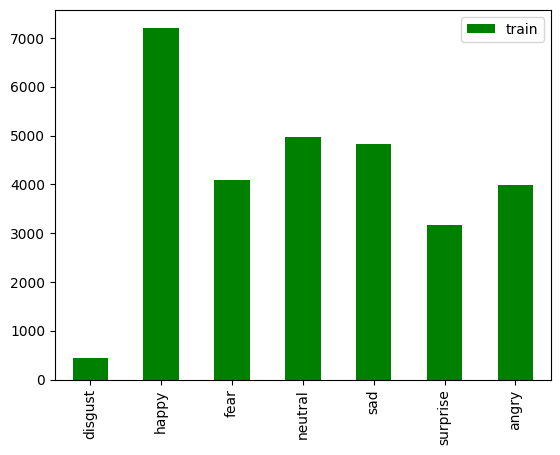

In [11]:
train_count.transpose().plot(kind='bar', color='green')

<Axes: >

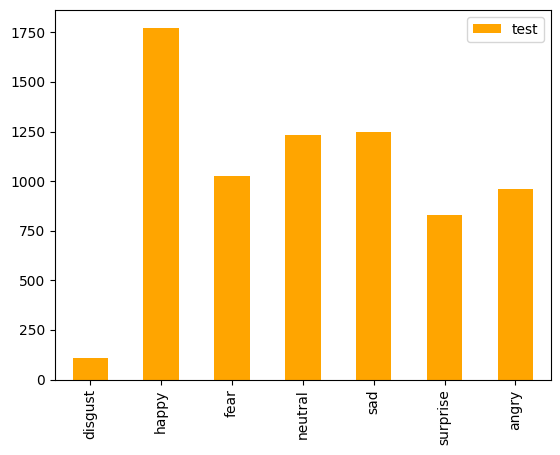

In [12]:
test_count.transpose().plot(kind='bar', color='orange')

## Plotting one image for each emotion

In [13]:
emotions = os.listdir(train_df)
print(emotions)

['disgust', 'happy', 'fear', 'neutral', 'sad', 'surprise', 'angry']


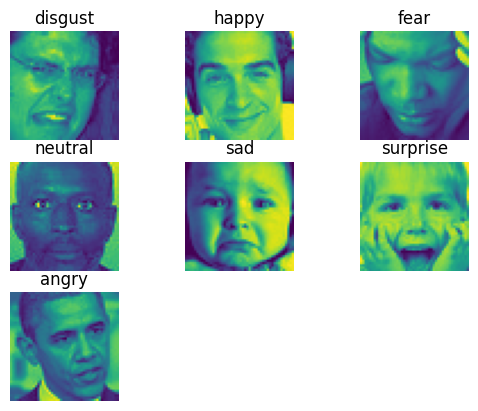

In [14]:
for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_df, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[5])
    img = plt.imread(img_path)
    plt.subplot(3,3, i)
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')

## Plotting random images from given directory

In [15]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    image_filenames = os.listdir(directory_path)

    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3,3, figsize=(5, 5))
    axes = axes.ravel()   #2D t0 1D

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

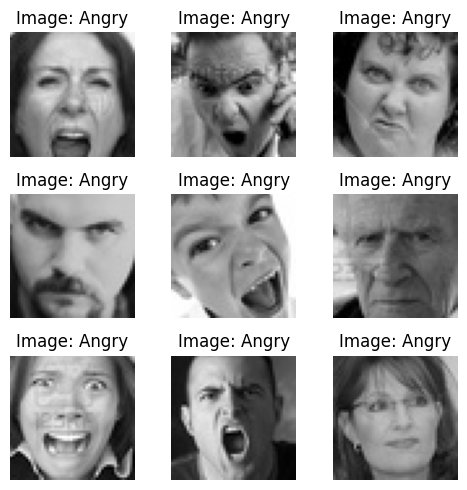

In [16]:
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

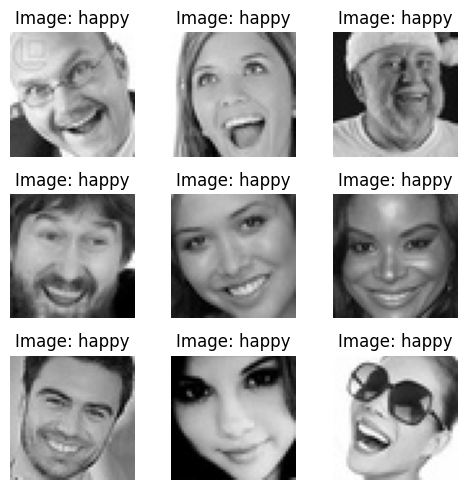

In [17]:
angry_directory_path = '/content/train/happy'
plot_images_from_directory(angry_directory_path, class_name = 'happy')

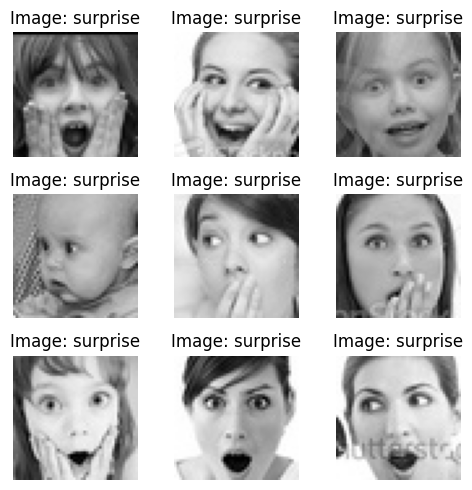

In [18]:
angry_directory_path = '/content/train/surprise'
plot_images_from_directory(angry_directory_path, class_name = 'surprise')

## Checking shape and channels.

In [19]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2
img = cv2.imread(image)
if img is not None:
    print("Shape:", img.shape)
else:
  print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


## Model 1 : Custom CNN from scratch

### Initializing the ImageGenerators

In [20]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [21]:
img_width ,img_height = 48,48
batch_size = 64
epochs = 10
num_classes =7

In [22]:
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

In [23]:
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    # subset='validation'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [24]:
train_class_label = train_generator.class_indices
print(train_class_label)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [25]:
test_class_label = test_generator.class_indices
print(test_class_label)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [26]:
validation_class_label = validation_generator.class_indices
print(validation_class_label)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


### Initialising the CNN

In [27]:
inputs =keras.Input(shape=(img_width, img_height, 1))

x = Rescaling(1./255)(inputs)

x = Conv2D(32,kernel_size=(3,3),kernel_initializer="glorot_uniform", padding='same',activation='relu')(x)
x = Conv2D(64,kernel_size=(3,3), padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x= Conv2D(128,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x= Conv2D(256,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x= Conv2D(512,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x= Conv2D(512,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes,activation='softmax')(x)

model = Model(inputs=inputs,outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      18,875,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │              

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

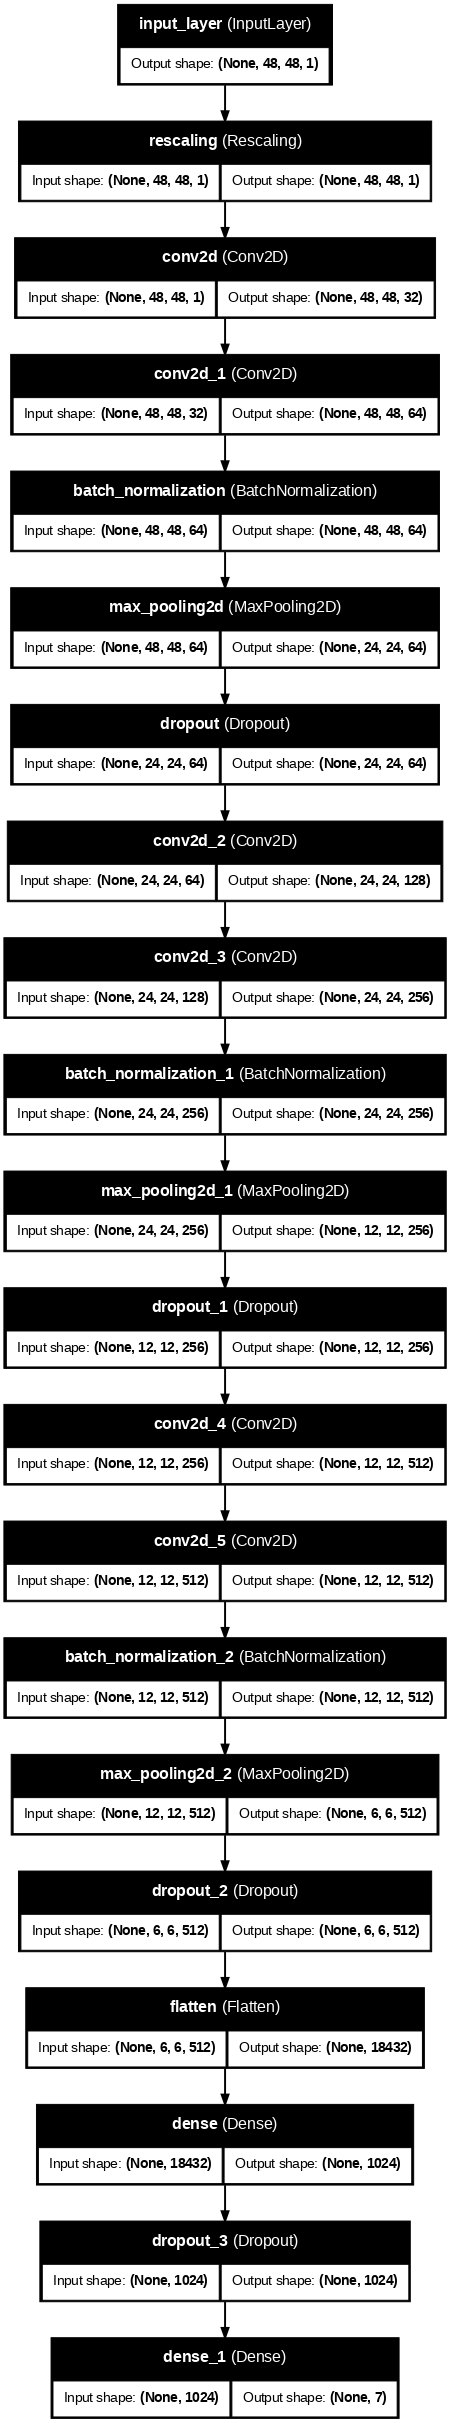

In [29]:
import pydot
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi=70)

## Callbacks

In [30]:
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [31]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [32]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [33]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [34]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr]  # Adjusted as per your use-case

## Steps for epoch

In [35]:
train_generator.samples

22968

In [36]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [37]:
print(train_steps_per_epoch)
print(validation_steps_epoch)
print(test_steps_epoch)

359
90
113


## Model Training

In [39]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks
)

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4961 - loss: 1.3478
Epoch 1: val_loss did not improve from 1.53471
359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.4961 - loss: 1.3479 - val_accuracy: 0.2580 - val_loss: 2.6155 - learning_rate: 0.0010
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5148 - loss: 1.3167
Epoch 2: val_loss improved from 1.53471 to 1.52979, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.5148 - loss: 1.3167 - val_accuracy: 0.4269 - val_loss: 1.5298 - learning_rate: 0.0010
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5293 - loss: 1.2835
Epoch 3: val_loss improved from 1.52979 to 1.33304, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.5293 - loss: 1.2835 - val_accuracy: 0.5166 - va

## Plotting Performance Metrics

In [40]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

## Model Evaluation

In [41]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.6247 - loss: 1.0905
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.5211 - loss: 1.3184
final train accuracy = 62.67 , validation accuracy = 53.00


##Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


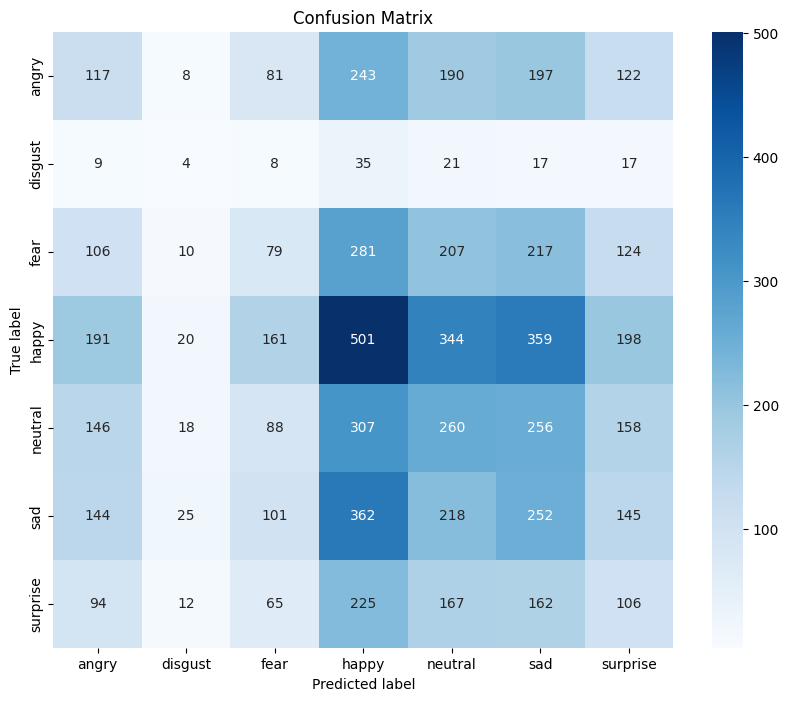

In [42]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1) # Convert steps to an integer
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Making Prediction

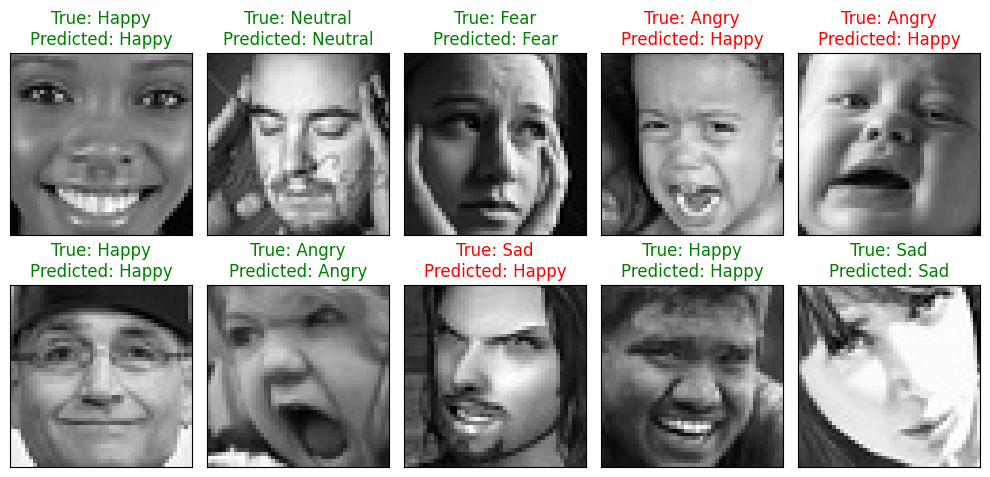

In [43]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    ax.imshow(Random_Img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

## Model 2 : Data Augmentation techniques

In [45]:
train_data_dir  = '/content/train'
test_data_dir = '/content/test'

In [46]:
# set some parameters
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

In [47]:
# Initializing the ImageDataGenerator
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'
)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [48]:
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [50]:
image_path = '/content/train/angry/Training_10118481.jpg'

# load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)

## Same CNN model as above

In [51]:
img_width, img_height = 48, 48
classes = 7

inputs =keras.Input(shape=(img_width, img_height, 1))

x = Rescaling(1./255)(inputs)

x = Conv2D(32,kernel_size=(3,3),kernel_initializer="glorot_uniform", padding='same',activation='relu')(x)
x = Conv2D(64,kernel_size=(3,3), padding='same',activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x= Conv2D(128,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x= Conv2D(256,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x= Conv2D(512,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x= Conv2D(512,kernel_size=(3,3), padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(num_classes,activation='softmax')(x)

model = Model(inputs=inputs,outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [checkpoint, earlystop, reduce_lr]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2320 - loss: 6.8476
Epoch 1: val_loss improved from inf to 1.90317, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 51s 116ms/step - accuracy: 0.2320 - loss: 6.8394 - val_accuracy: 0.2513 - val_loss: 1.9032 - learning_rate: 0.0010
Epoch 2/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2421 - loss: 1.8458
Epoch 2: val_loss improved from 1.90317 to 1.81448, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.2421 - loss: 1.8457 - val_accuracy: 0.2275 - val_loss: 1.8145 - learning_rate: 0.0010
Epoch 3/20
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.2548 - loss: 1.7941
Epoch 3: val_loss improved from 1.81448 to 1.80702, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Cu

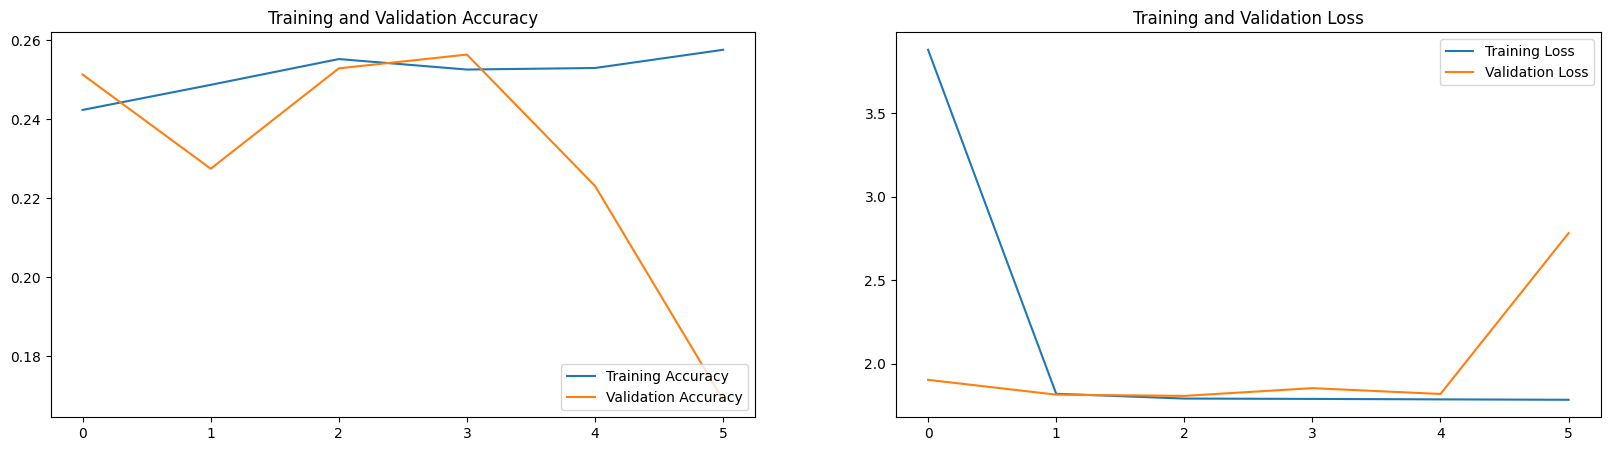

In [52]:
plot_training_history(history)

In [53]:
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100,test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.2505 - loss: 1.8050
  3/113 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2135 - loss: 1.7551

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2500 - loss: 1.7954
final train accuracy = 25.44 , validation accuracy = 25.01


113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step


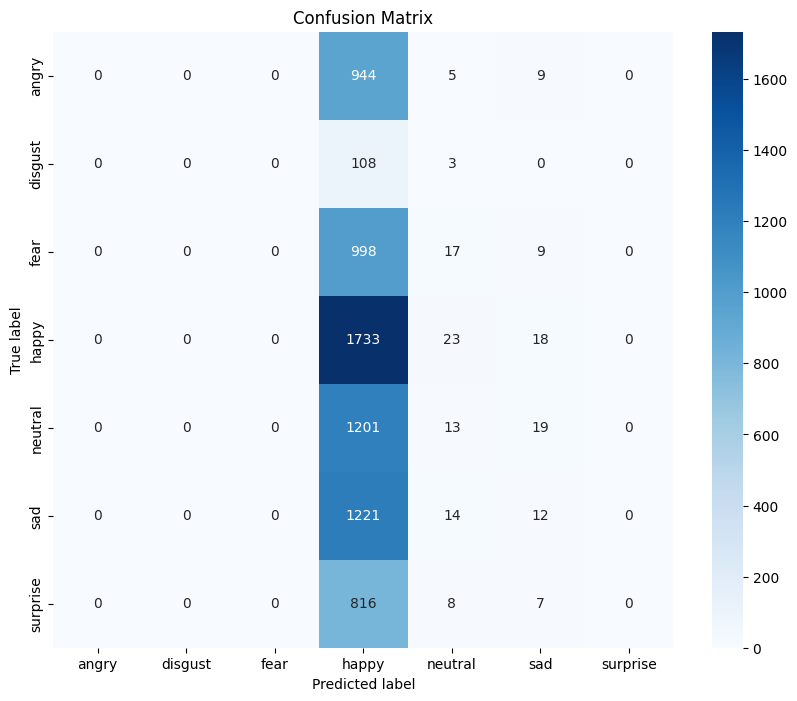

In [54]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1) # Convert steps to an integer
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

##Model 3 : Transfer Learning VGGNET

In [55]:
train_data_dir  = '/content/train'
test_data_dir = '/content/test'

In [56]:
img_width,img_height = 224,244
batch_size=64
epochs = 10
num_classes=7

In [57]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)
test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [58]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

class_weights_dict = dict(enumerate(class_weights))
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [59]:
classes = 7
tf.keras.backend.clear_session()

vgg= VGG16(input_shape=(img_width,img_height,3),
           include_top=False,
           weights='imagenet')
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [62]:
# Fully connected neural network
x = Flatten()(vgg.output)

x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

model = Model(inputs=vgg.input, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 30,939,143 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [63]:
cnn_path = '/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [checkpoint, earlystop, reduce_lr]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.1963 - loss: 1.9952
Epoch 1: val_loss improved from inf to 1.56445, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step - accuracy: 0.1964 - loss: 1.9949 - val_accuracy: 0.3899 - val_loss: 1.5644 - learning_rate: 1.0000e-04
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 892ms/step - accuracy: 0.3493 - loss: 1.6807
Epoch 2: val_loss improved from 1.56445 to 1.50100, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 470s 990ms/step - accuracy: 0.3493 - loss: 1.6806 - val_accuracy: 0.4189 - val_loss: 1.5010 - learning_rate: 1.0000e-04
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.4054 - loss: 1.5609
Epoch 3: val_loss improved from 1.50100 to 1.41726, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/V

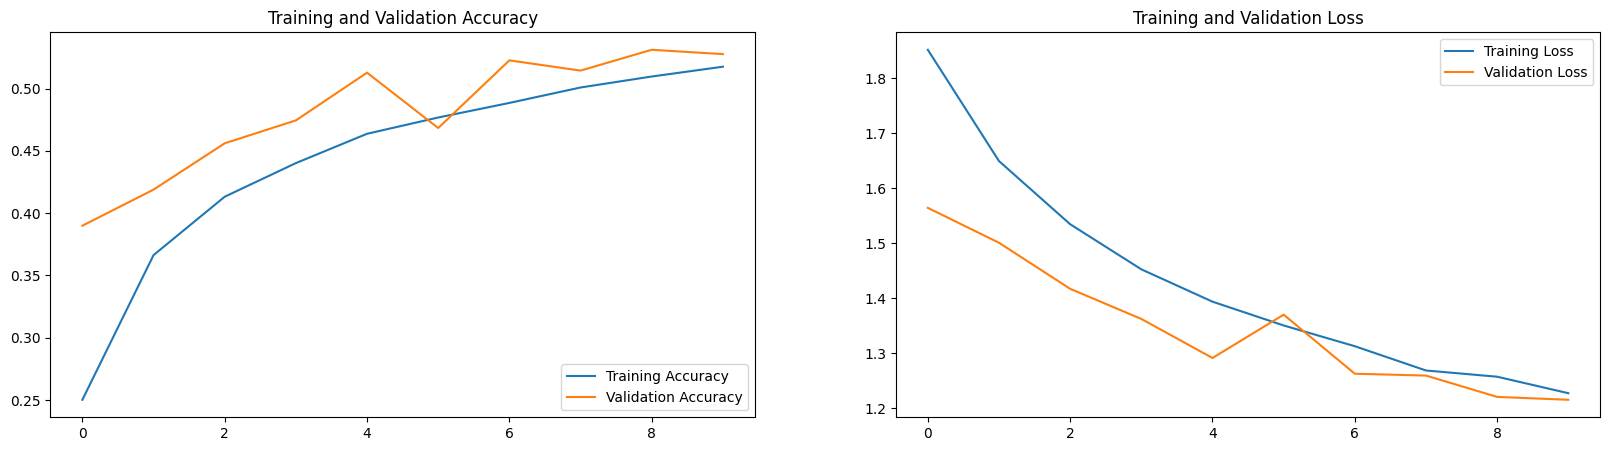

In [64]:
plot_training_history(history)

In [65]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 396s 880ms/step - accuracy: 0.5309 - loss: 1.2209
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 362ms/step - accuracy: 0.5322 - loss: 1.2211
final train accuracy = 52.98 , validation accuracy = 52.77


## Model 4 : Transfer Learning ResNet50

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

batch_size = 128

train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )
test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights Dictionary:", class_weights_dict)

In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

In [ ]:
ResNet50V2.trainable = True
for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
cnn_path = '/content/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
                              verbose=1)

callbacks = [checkpoint, earlystop]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=20,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

In [ ]:
plot_training_history(train_history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Model Deployment
### We will do deployment using gradio